The main reason that the KL divergence of $P(k)$ is negative is because there's a significant bias caused by the $k$-NN estimator. 

In [1]:
import numpy as np
from scipy.special import gamma as Gamma
from scipy.special import gammaln as GammaLn
from numpy.random import multivariate_normal as mvn 
from scipy.stats import multivariate_normal as multinorm
#
from sklearn.neighbors import NearestNeighbors
# -- nonGaussLike -- 
from nongausslike import knn as kNN
from nongausslike import nongauss as NG

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
X_pk = NG.X_pk_all('patchy.z1', NorS='ngc', sys='fc')
X_res, _ = NG.meansub(X_pk)
X_w, W = NG.whiten(X_res)
C_x = np.cov(X_w.T)

n, dim = X_pk.shape
print("%i dimensional data with %i samples" % (dim, n))

X_ref = mvn(np.zeros(dim), C_x, size=n)

37 dimensional data with 2048 samples


In [4]:
def X_sample(nn): 
    return mvn(np.zeros(dim), C_x, size=nn)

In [5]:
def c_1(d): 
    return np.pi**(0.5 * float(d)) / Gamma(0.5*float(d)+1)

In [6]:
def hat_p(X, k=10): 
    n, d = X.shape # n and dimensions
    k, n, d = float(k), float(n), float(d)

    # kNN term
    NN_X = NearestNeighbors(n_neighbors=int(k)).fit(X)
    dNN_XX, _ = NN_X.kneighbors(X, n_neighbors=int(k)+1) # k+1 to exclude itself
    rho_k_i = dNN_XX[:,-1]
    
    return k/(n-1) * 1 / (c_1(d) * rho_k_i**d)

In [7]:
def p(X): 
    return multinorm.pdf(X, mean=np.zeros(dim), cov=C_x)

We're trying to estimate 

$$\int p(x) \log p(x) dx \approx \sum\limits_{i=1}^{n} \log p(X_i)$$

In [8]:
X_ref_dense = X_sample(100000)
int_plogp_true = 1./100000. * np.sum(np.log(p(X_ref_dense)))

In [9]:
print int_plogp_true

-52.49174806680252


In [10]:
ks = [1, 3, 5, 7, 10, 15, 20, 100]#, 1000]
pX_ref = p(X_ref)
hat_pX_ref = []
for k in ks: 
    hat_pX_ref.append(hat_p(X_ref, k=k))
hat_pX_ref = np.array(hat_pX_ref)

Text(0.5,0,'$k$')

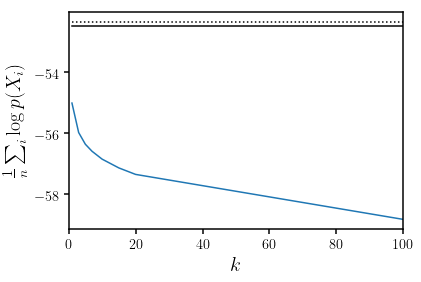

In [11]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ks, np.average(np.log(hat_pX_ref), axis=1))
sub.plot(ks, np.repeat(np.average(np.log(pX_ref)), len(ks)), c='k', ls=':')
sub.plot(ks, np.repeat(int_plogp_true, len(ks)), c='k', ls='-')
sub.set_xlim([0, ks[-1]])
sub.set_ylabel(r'$\frac{1}{n}\sum_{i} \log p(X_i)$', fontsize=20)
#sub.set_yscale('log')
sub.set_xlabel('$k$', fontsize=20)

In [17]:
ns = [2000, 4000, 6000, 8000, 10000, 20000]
hat_plogp_ns, hat_plogp_1nn_ns, hat_plogp_5nn_ns, hat_plogp_10nn_ns = [], [], [], [] 
for n in ns: 
    Xn = X_sample(n)
    hat_plogp_ns.append(np.average(np.log(p(Xn))))
    hat_plogp_1nn_ns.append(np.average(np.log(hat_p(Xn, k=1))))
    hat_plogp_5nn_ns.append(np.average(np.log(hat_p(Xn, k=5))))
    hat_plogp_10nn_ns.append(np.average(np.log(hat_p(Xn, k=10))))

Text(0.5,0,'$n$')

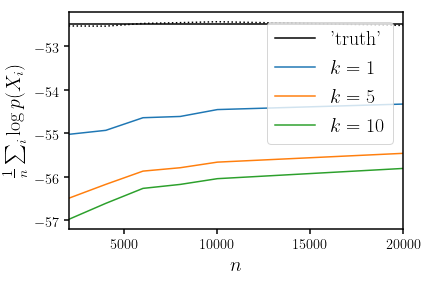

In [20]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, hat_plogp_ns, c='k', ls=':')
sub.plot(ns, np.repeat(int_plogp_true, len(ns)), c='k', ls='-', label="'truth'")
sub.plot(ns, hat_plogp_1nn_ns, label='$k=1$')
sub.plot(ns, hat_plogp_5nn_ns, label='$k=5$')
sub.plot(ns, hat_plogp_10nn_ns, label='$k=10$')
sub.legend(loc='upper right', frameon=True, fontsize=20)
sub.set_xlim([ns[0], ns[-1]])
sub.set_ylabel(r'$\frac{1}{n}\sum_{i} \log p(X_i)$', fontsize=20)
#sub.set_yscale('log')
sub.set_xlabel('$n$', fontsize=20)

In [21]:
def X_sample_lowd(nn): 
    return mvn(np.zeros(5), C_x[:5,:5], size=nn)

In [25]:
def p_lowd(X): 
    return multinorm.pdf(X, mean=np.zeros(5), cov=C_x[:5,:5])

In [26]:
X_ref_dense_lowd = X_sample_lowd(100000)
int_plogp_true = 1./100000. * np.sum(np.log(p_lowd(X_ref_dense_lowd)))

In [30]:
ns = [2000, 4000, 6000, 8000, 10000, 20000]
hat_plogp_ns, hat_plogp_1nn_ns, hat_plogp_5nn_ns, hat_plogp_10nn_ns, hat_plogp_100nn_ns = [], [], [], [], [] 
for n in ns: 
    Xn = X_sample_lowd(n)
    hat_plogp_ns.append(np.average(np.log(p_lowd(Xn))))
    hat_plogp_1nn_ns.append(np.average(np.log(hat_p(Xn, k=1))))
    hat_plogp_5nn_ns.append(np.average(np.log(hat_p(Xn, k=5))))
    hat_plogp_10nn_ns.append(np.average(np.log(hat_p(Xn, k=10))))
    hat_plogp_100nn_ns.append(np.average(np.log(hat_p(Xn, k=100))))

Text(0.5,0,'$n$')

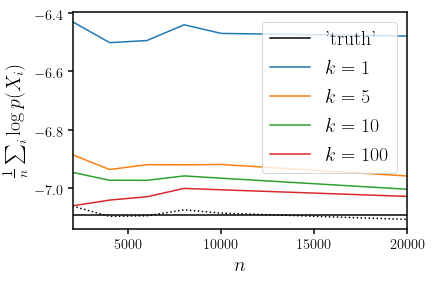

In [31]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, hat_plogp_ns, c='k', ls=':')
sub.plot(ns, np.repeat(int_plogp_true, len(ns)), c='k', ls='-', label="'truth'")
sub.plot(ns, hat_plogp_1nn_ns, label='$k=1$')
sub.plot(ns, hat_plogp_5nn_ns, label='$k=5$')
sub.plot(ns, hat_plogp_10nn_ns, label='$k=10$')
sub.plot(ns, hat_plogp_100nn_ns, label='$k=100$')
sub.legend(loc='upper right', frameon=True, fontsize=20)
sub.set_xlim([ns[0], ns[-1]])
sub.set_ylabel(r'$\frac{1}{n}\sum_{i} \log p(X_i)$', fontsize=20)
#sub.set_yscale('log')
sub.set_xlabel('$n$', fontsize=20)